In [ ]:
from flask import Flask
from flask_sockets import Sockets
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.animation as anim
import time

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)


def plot_cont(xi, xmax):
    y = []
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    def update(i):
        #yi = fun()
        y.append(xi)
        x = range(len(y))
        ax.clear()
        ax.plot(x, y)
        #print(i, ': ', xi)

    a = anim.FuncAnimation(fig, update, frames=xmax, repeat=False)
    plt.show()


fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

def animate(i):
    pullData = open("sampleText.txt","r").read()
    dataArray = pullData.split('\n')
    xar = []
    yar = []
    for eachLine in dataArray:
        if len(eachLine)>1:
            x,y = eachLine.split(',')
            xar.append(int(x))
            yar.append(int(y))
    ax1.clear()
    ax1.plot(xar,yar)
ani = animation.FuncAnimation(fig, animate, interval=1000)
plt.show()



fig = plt.figure()
ax = fig.add_subplot(1, 1, 1) 

for i in range(20):
    x = np.arange(0, i, 0.1);
    y = np.sin(x)
    
    ax.set_xlim(0, i)
    
    ax.cla()
    ax.plot(x, y)
    display(fig)
    
    clear_output(wait = True)
    plt.pause(0.5)

In [ ]:
accelX=[]
times=[]

In [39]:
from flask import Flask
from flask_sockets import Sockets
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#from scipy.signal import savgol_filter
#from scipy.interpolate import spline
from scipy.signal import lfilter
import slidingwindow as sw
import pandas as pd
import statistics
import numpy as np
import time
import keras
from keras.models import Sequential
from keras.layers import Dense
from scipy.spatial.distance import cosine
from scipy.sparse import csr_matrix
from keras.utils import to_categorical

%matplotlib inline
from IPython.display import display, clear_output



from keras.models import load_model


mylist = ["Ax", "Ay", "Az","Gx", "Gy", "Gz", "Mx", "My","Mz"]
# Returns a compiled model identical to the previous one
model = load_model('my_Model.h5')
n_training = 30  # number of trials used for training, the rest for validation
n_components = 40 # PCA components
imu_dimensions = 4 # number of dimensions in imu data

classes = ['move', 'scratch', 'work', 'relax']

window_size=50


def timeSeriesToSupervised(df,var_list,window_size=1, dropnan=True):
    for var in var_list:
        for idx in range(window_size,0,-1):
            var_name = var + '(t+' + str(idx) + ')'    
            df[var_name] = df[var].shift(-idx)

    if dropnan:
        df.dropna(inplace=True)
    return df



starttime = time.time()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1) 



app = Flask(__name__)

sockets = Sockets(app)

accelX=[]
accelY=[]
accelZ=[]
times=[]
sadtimes=[]
gyroX=[]
gyroY=[]
gyroZ=[]
magX=[]
magY=[]
magZ=[]
rangeval = 20
windows=[]


    

def converter(types, val):
    a = []
    temp = ""
    for x in val:
        if x == ",":
            a.append(float(temp))
            temp = ""
        else:
            temp += x
    a.append(float(temp))
    thisdict = {}
    if types in ("accel", "gyro" "mag"):
        thisdict = {"x": a[0], "y": a[1], "z": a[2]}
    elif types == "oriet":
        thisdict = {"azmuth": a[0], "pitch": a[1], "roll": a[2]}

    return thisdict


def Filter(arr):
    M=mean(arr)
    sd=stdev(arr)
    th=sd*2
    #arr(map(lambda x: ))
    return arr


@sockets.route('/accelerometer')
def echo_socket(ws):
    count=0
    f = open("accelerometer.txt", "a")
    while True:
        message = ws.receive()
        a = converter("accel", message)
        accelX.append(a['x'])
        accelY.append(a['y'])
        accelZ.append(a['z'])
        ts=time.time()
        times.append(ts)
        sadtimes.append(ts - starttime)
        sadtimes = list(filter(lambda x: x >= max(0, max(times) - rangeval), times))
        sadaccelX = accelX[max(len(times) - len(sadtimes), 0): ]
        sadaccelY = accelY[max(len(times) - len(sadtimes), 0): ]
        sadaccelZ = accelZ[max(len(times) - len(sadtimes), 0): ]
        count+=1
        if count>=window_size:
            df = pd.DataFrame({'Time_Stamp':times,'Ax':accelX,'Ay':accelY,'Az':accelZ,'Gx':gyroX,'Gy':gyroY,'Gz':gyroZ,'Mx':magX,'My':magY,'Mz':magZ})
            df2= timeSeriesToSupervised(df,mylist,window_size)
            X = df2.drop('Time_Stamp', axis=1)
            y_pred = model.predict(X)
            print(y_pred)
            #yhat = savgol_filter(accelX,10, 3)
            #b=np.asarray(accelX)
#             n = 11  # the larger n is, the smoother curve will be
#             b = [1.0 / n] * n
#             a = 1
#             yhat = lfilter(b,a,accelX)
            #yhat=np.linspace(b.min(),b.max(),11)
            #df = pd.DataFrame({'col':sadaccelX})
            
            ax.set_xlim(0, max(max(sadtimes), 60))
            ax.cla()
            ax.plot(sadtimes, sadaccelX)
            ax.plot(sadtimes,sadaccelY, color='red')
            ax.plot(sadtimes,sadaccelZ, color='yellow')
            #ax.plot(sadtimes,df.col.rolling(9).mean(),color='grey')
            display(fig)

            clear_output(wait = True)
            plt.pause(0.005)
            count=0

            
            
#         plt.scatter(ts, a['x'])
        
#         plt.show()
#         #plt.clf()
#         plt.plot( times, accelX)
#         plt.show()
#         plt.pause(0.0001)

        #ax1.plot( times, accelY)
        #ax1.plot( times, accelZ)
        #print("hello");
        #ax.plot(a["x"], a["y"])
        #fig.show()
        #plot_cont(a["x"], 60)
        ws.send(message)
        
    


@sockets.route('/gyroscope')
def echo_socket(ws):
    f = open("gyroscope.txt", "a")
    while True:
        message = ws.receive()
        a = converter("gyro", message)
        gyroX.append(a['x'])
        gyroY.append(a['y'])
        gyroZ.append(a['z'])
        
        ws.send(message)
        #print(message, file=f)
    f.close()


@sockets.route('/magnetometer')
def echo_socket(ws):
    f = open("magnetometer.txt", "a")
    while True:
        message = ws.receive()
        a = converter("mag", message)
        magX.append(a['x'])
        magY.append(a['y'])
        magZ.append(a['z'])
       #print(message)
        ws.send(message)
       # print(message, file=f)
    f.close()


@sockets.route('/orientation')
def echo_socket(ws):
    f = open("orientation.txt", "a")
    while True:
        message = ws.receive()
        print(message)
        ws.send(message)
        print(message, file=f)
    f.close()


@sockets.route('/stepcounter')
def echo_socket(ws):
    f = open("stepcounter.txt", "a")
    while True:
        message = ws.receive()
        print(message)
        ws.send(message)
        print(message, file=f)
    f.close()


@sockets.route('/thermometer')
def echo_socket(ws):
    f = open("thermometer.txt", "a")
    while True:
        message = ws.receive()
        print(message)
        ws.send(message)
        print(message, file=f)
    f.close()


@sockets.route('/lightsensor')
def echo_socket(ws):
    f = open("lightsensor.txt", "a")
    while True:
        message = ws.receive()
        print(message)
        ws.send(message)
        print(message, file=f)
    f.close()


@sockets.route('/proximity')
def echo_socket(ws):
    f = open("proximity.txt", "a")
    while True:
        message = ws.receive()
        print(message)
        ws.send(message)
        print(message, file=f)
    f.close()


@sockets.route('/geolocation')
def echo_socket(ws):
    f = open("geolocation.txt", "a")
    while True:
        message = ws.receive()
        print(message)
        ws.send(message)
        print(message, file=f)
    f.close()


@app.route('/')
def hello():
    return 'Hello World!'




if __name__ == "__main__":
    from gevent import pywsgi
    from geventwebsocket.handler import WebSocketHandler
    
    server = pywsgi.WSGIServer(
        ('0.0.0.0', 5000), app, handler_class=WebSocketHandler)
    server.serve_forever()
    


ValueError: Unknown layer:name

In [35]:
d = {'T':times,'Ax':accelX,'Ay':accelY,'Az':accelZ}
Cdata=pd.DataFrame(d)
computeIMUFeatures(Cdata)


TypeError: unhashable type: 'slice'

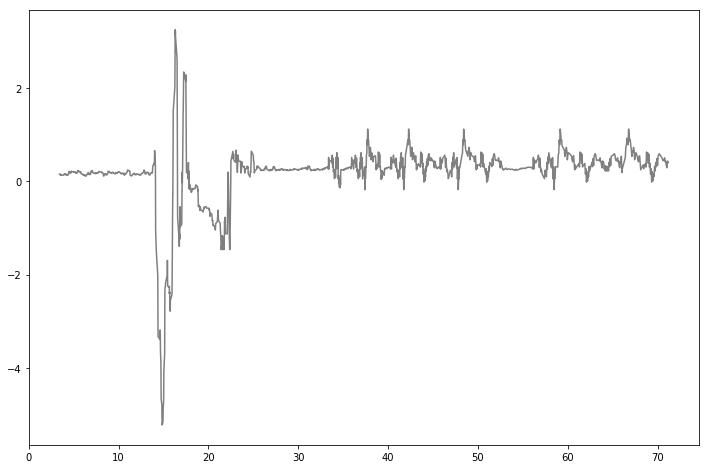

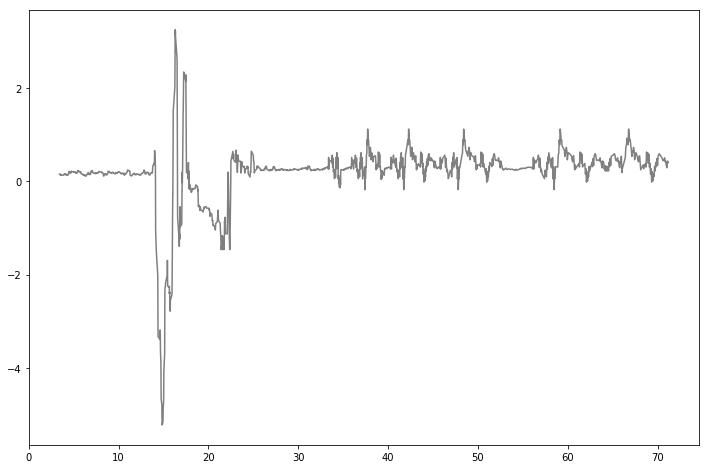

In [29]:
#MOVING AVERAGE IS ALSO A GOOD FILTER FOR FOOT TAPPING YOLO
fig2 = plt.figure(figsize=(12,8))
axl = fig2.add_subplot(1, 1, 1) 

df = pd.DataFrame({'col':accelX})
#axl.plot(times,accelX)
#ax.plot(times,accelY, color='red')
#ax.plot(times,accelZ, color='yellow')
axl.plot(times,df.col.rolling(9).mean(),color='grey')
display(fig2)


In [9]:

windows = sw.generate(np.array(accelX), sw.DimOrder.HeightWidthChannel, window_size, 0.5)



IndexError: tuple index out of range

In [ ]:
print(f"From:{max(0, max(times) - 60)}, To:{max(max(times), 60)}")

In [ ]:
# butterworths filter to noisy foot data seems usefull but not on naibiting

import pandas as pd  
import numpy as np
import matplotlib.pyplot 
from pandas import read_csv
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal

print(accelX)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,1,1)
#ax1.plot(times,accelX)
fs = 1000
fc = 30  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(15, w, 'low')
output = signal.filtfilt(b, a, accelX)
t = times
# plt.plot(t, output, label='filtered')
ax1.plot(times,accelX, color='red')
ax1.plot(t,output, color='yellow')
display(fig)


In [ ]:
from time import sleep
import numpy as np
import os
from sklearn.externals import joblib
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import animation
from drawnow import drawnow, figure

display_size = 100
window_size = 40
classify_interval = 20 # run classification every 20 data points

pca = joblib.load('models/pca.pkl')
clf = joblib.load('models/classifier.pkl')

classes = ['move', 'scratch', 'work', 'relax']
currentClassifyLabel = ''

running_acc_data = np.empty(shape=(0, 3))
running_gyro_data = np.empty(shape=(0, 3))
classifyCounter = 0

class Listener(DeviceListener):
    runningClusters = np.empty(shape=(0), dtype=int)
    runningData = np.empty(shape=(0, 8))

    def on_connect(self, myo, timestamp, firmware_version):
        myo.set_stream_emg(StreamEmg.enabled)

    def on_pair(self, myo, timestamp, firmware_version):
        print("Hello, Myo!")

    def on_unpair(self, myo, timestamp):
        print("Goodbye, Myo!")

    def on_gyroscope_data(self, event, timestamp, gy):
        global running_gyro_data
        #print ("on gy: ", gy)
        running_gyro_data = np.append(running_gyro_data, np.expand_dims(np.array(list(gy)), axis=0), axis=0)
        running_gyro_data = running_gyro_data[-1*100:, :]

    def on_accelerometor_data(self, event, timestamp, acc):
        global running_acc_data, running_gyro_data, classifyCounter, currentClassifyLabel, classes
        #print ("on acc: ", acc)
        running_acc_data = np.append(running_acc_data, np.expand_dims(np.array(list(acc)), axis=0), axis=0)
        running_acc_data = running_acc_data[-1*100:, :]

        classifyCounter += 1
        if running_acc_data.shape[0] >= window_size and running_gyro_data.shape[0] >= window_size and classifyCounter % classify_interval == 0:

            acc_data = running_acc_data[-1*window_size:,:]
            gyro_data = running_gyro_data[-1*window_size:,:]
            imu_data = np.append(acc_data, gyro_data, axis=1)

            print (imu_data)

            fft = np.abs(np.fft.fft(imu_data, axis=0))
            fft = fft.reshape(-1)

            reducedX = pca.transform(np.expand_dims(fft, axis=0))
            cls = clf.predict(reducedX)

            currentClassifyLabel = classes[int(cls[0])]

def update_line(lines, classifyLabel):
    global running_acc_data, running_gyro_data, currentClassifyLabel
    minSize = min(running_acc_data.shape[0], running_gyro_data.shape[0])
    imu_data = np.append(running_acc_data[:minSize], running_gyro_data[:minSize], axis=1)

    classifyLabel.set_text(currentClassifyLabel)
    if currentClassifyLabel == 'scratch':
        classifyLabel.set_bbox({'facecolor':'red', 'alpha':0.5, 'pad':10})
    else:
        classifyLabel.set_bbox({'facecolor':'green', 'alpha':0.5, 'pad':10})

    for i in range(6):
        d1 = np.transpose(imu_data[:, i])
        dd = np.append(np.expand_dims(np.array(range(imu_data.shape[0])), axis=0), np.expand_dims(d1, axis=0), axis=0)
        lines[i].set_data(dd)
    return lines[0], lines[1], lines[2], lines[3], lines[4], lines[5],

fig = plt.figure()
plt.rc('font', size=8)
lines = []
for i in range(6):
    ax = fig.add_subplot(7, 1, (i+2))
    ax.set_xlim([0, 100])
    if i < 3:
        ax.set_ylim([-2, 2])
    else:
        ax.set_ylim([-100, 100])
    l, = ax.plot([])
    lines.append(l)

classifyLabel = plt.text(30, 1500, '--', style='italic', fontsize=30, bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})

plt.ion()
plt.show()

init()
hub = Hub()
hub.run(1000, Listener())
try:
    while True:
        sleep(0.01)
        update_line(lines, classifyLabel)
        plt.draw()
        plt.pause(0.001)
except KeyboardInterrupt:
    print('\nQuit')
finally:
    hub.shutdown()  # !! crucial